# Movie review sentiment analysis

## 네이버 영화 리뷰 댓글 데이터인 NSMC를 이용한 감성분석

- [NSMC](https://github.com/e9t/nsmc)


### Import libraries

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1. 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.isnull().sum()) #결측치 확인

train_data.head()

id          0
document    5
label       0
dtype: int64


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 데이터 중복 제거(중복된 데이터가 과적합 유발, 불필요한 계산 증가)
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # 결측치 제거
    train_data.dropna(how='any', inplace=True)
    test_data.dropna(how='any', inplace=True)

    # 한국어 토크나이저로 토큰화 및 불용어(stopwords)처리
    X_train, X_test = [], []

    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어처리
        X_train.append(temp_X)

    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어처리
        X_test.append(temp_X)


    # 사전 word_to_index 구성

    ## 단어 빈도 계산
    words = np.concatenate(X_train).tolist() # X_train의 배열들을 합치고 리스트로 변환
    counter = Counter(words) # words 의 단어들의 빈도 계산
    counter = counter.most_common(10000-4) # 가장 빈도높은 9996개의 (단어, 빈도)를 저장
    vocab = ['', '', '', ''] + [key for key, _ in counter] #counter의 값 중 value는 무시하고 key만 vocab에 저장
    word_to_index = {word:index for index, word in enumerate(vocab)} #어휘 목록(vocab)을 기반으로 단어를 인덱스로 매핑하는 딕셔너리인 word_to_index을 생성

    ## 사전 구성
    def wordlist_to_indexlist(wordlist):
        # wordlist의 단어들을 word_to_index 딕셔너리를 활용해 정수 인덱스로 변환
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))


    return X_train, np.array(list(train_data['label'])), X_test, np.array(test_data['label']), word_to_index
    

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}


In [6]:
# 문장 1개를 단어 인덱스 리스트 벡터로 변환해주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 문장 여러개를 단어 인덱스 리스트 벡터로 변환해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자벡터로 encoding된 문장 하나를 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encoding된 문장을 한꺼번여 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


### 3. 모델 구성을 위한 데이터 분석 및 가공

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


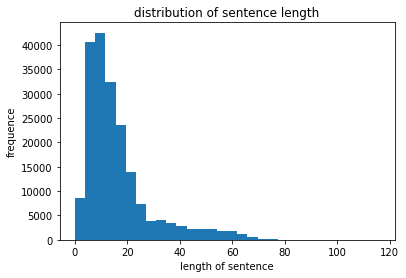

In [7]:
import matplotlib.pyplot as plt

# 전체 데이터 통합
total_data_text = list(X_train) + list(X_test)
sentence_lengths = [len(sentence) for sentence in total_data_text]

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(sentence_lengths))
print('문장길이 최대 : ', np.max(sentence_lengths))
print('문장길이 표준편차 : ', np.std(sentence_lengths))

# 그래프
plt.hist(sentence_lengths, bins=30)
plt.xlabel('length of sentence')
plt.ylabel('frequence')
plt.title('distribution of sentence length')
plt.show()

- 데이터셋 내 문장길이 분포는 10~20 사이가 가장 빈도가 높다.
- 데이터셋 내 문장길이의 평균은 약 16이다.
- 따라서 최대 문장 길이는 (평균 + 2*표준편차)인 16 + 24 = 40으로 설정할 것이다.


In [8]:
maxlen = 40

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[""],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)


(146182, 40)


### 4. 모델 구성 및 validation set 구성

#### validation set 구성

In [9]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 40)
(136182,)


In [10]:
# RNN

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
rnn_model = tf.keras.Sequential()
# [[YOUR CODE]]
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
rnn_model.add(tf.keras.layers.LSTM(8))
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시

In [14]:
# rnn
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.4896 - accuracy: 0.7877 - val_loss: 0.3587 - val_accuracy: 0.8466
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3424 - accuracy: 0.8561 - val_loss: 0.3442 - val_accuracy: 0.8511
Epoch 3/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3223 - accuracy: 0.8665 - val_loss: 0.3432 - val_accuracy: 0.8488
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3132 - accuracy: 0.8700 - val_loss: 0.3434 - val_accuracy: 0.8506
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3059 - accuracy: 0.8737 - val_loss: 0.3480 - val_accuracy: 0.8471
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2987 - accuracy: 0.8757 - val_loss: 0.3452 - val_accuracy: 0.8514
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8791 - val_loss: 0.3424 - val_accuracy: 0.8528
Epoch 

In [16]:
results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4806 - accuracy: 0.8409
[0.4806264042854309, 0.8409178853034973]


### 6. loss, accuracy 그래프 시각화

In [17]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


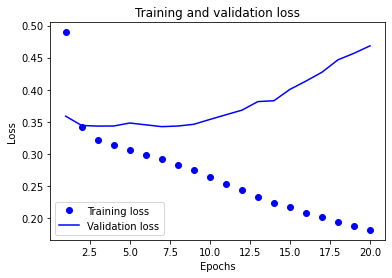

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

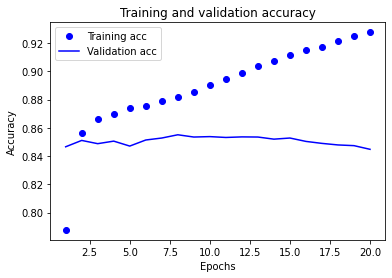

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

epoch이 2일때가 좋다??

### 7. 학습된 embedding layer 분석

In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 학습된 임베딩 레이어에서 단어 벡터 추출
word_vectors = rnn_model.get_layer('embedding').get_weights()[0]

# 단어 간 코사인 유사도 계산
def get_word_similarity(word1, word2):
    idx1 = word_to_index[word1]
    idx2 = word_to_index[word2]
    vec1 = word_vectors[idx1]
    vec2 = word_vectors[idx2]
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity

# 두 단어의 유사도 계산 예시
word1 = '사랑'
word2 = '행복'
similarity = get_word_similarity(word1, word2)
print(f"단어 '{word1}'와 '{word2}'의 유사도: {similarity}")


단어 '사랑'와 '행복'의 유사도: 0.9270002245903015


In [23]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.11100206,  0.08263732, -0.05293398, -0.02562785,  0.08096495,
        0.02026113,  0.10851345,  0.1054933 , -0.12687898,  0.07849126,
       -0.08916201,  0.21566883,  0.04391343,  0.03127477, -0.02409972,
       -0.1754617 ], dtype=float32)

In [29]:
word_vectors.similar_by_word("감동")

[('풀어낸', 0.9677829146385193),
 ('브라이언', 0.9542179107666016),
 ('프랭크', 0.9521015882492065),
 ('눈깔', 0.9516242146492004),
 ('젊은이', 0.9488844871520996),
 ('이동욱', 0.9463967680931091),
 ('퍼센트', 0.9459674954414368),
 ('일어날', 0.944931149482727),
 ('best', 0.9441491365432739),
 ('와우', 0.9433453679084778)]

### 8. 한국어 Word2Vec embedding을 활용해 성능 개선

In [40]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['감동']


In [50]:
vector

array([ 2.0615332 , -1.8058181 , -3.8560703 ,  0.19584662,  3.0254989 ,
       -2.5406559 ,  1.4497426 , -0.8907619 , -0.5350154 , -0.28915498,
       -0.04039751, -1.5070994 , -1.5159569 , -1.4451234 ,  1.2730805 ,
        1.219924  ,  1.1764907 , -1.1386696 ,  1.4214209 ,  0.03967131,
       -2.1550455 ,  2.365588  ,  2.5686727 , -2.298423  , -0.11259492,
        0.26295963, -1.3272469 , -0.933552  ,  4.1928024 , -4.142401  ,
       -3.6939445 ,  0.7796591 , -0.9809508 ,  0.3209224 ,  0.69489354,
        0.35386428, -2.5914404 ,  0.9266287 , -1.8625584 ,  0.7818586 ,
       -0.9435029 , -0.50120497,  1.4713919 ,  4.4542685 , -1.2020006 ,
        0.41612652,  2.3063416 , -0.41137695,  4.462475  , -1.5086855 ,
        2.0054195 ,  0.8322103 ,  3.0386746 , -1.1280597 , -0.819387  ,
       -3.6409898 ,  1.4442042 , -0.6339732 ,  0.25369656, -0.39272726,
        1.6376917 , -2.6886675 ,  0.41585886, -2.772139  ,  0.59364617,
        0.98523784,  2.0588415 ,  0.22607008, -1.26653   , -1.01